# Architecture-Based Tenant Replication with Visualization

This notebook demonstrates the complete architecture-based replication workflow:

1. **Pattern Detection**: Analyze source tenant and detect architectural patterns
2. **Instance Selection**: Select connected architectural instances
3. **Target Graph Building**: Build target pattern graph from selected instances
4. **Visualization & Comparison**: Compare source vs target graphs

## Key Concepts

- **Pattern Graph**: Type-level aggregation of the instance resource graph
- **Architectural Instances**: Groups of resources sharing a **ResourceGroup** (common parent)
- **Goal**: Build target pattern graph that MATCHES source pattern graph structure
- **Spectral Distance**: Mathematical measure of structural similarity (lower = better)

## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import numpy as np

sys.path.insert(0, str(Path.cwd().parent))

# Force reload the module to pick up any code changes
import importlib
if 'src.architecture_based_replicator' in sys.modules:
    importlib.reload(sys.modules['src.architecture_based_replicator'])

from src.architecture_based_replicator import ArchitectureBasedReplicator

# Set up matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Verify the fix is in the code
import inspect
source_code = inspect.getsource(ArchitectureBasedReplicator._build_target_pattern_graph_from_instances)
if "First, add ALL resource types from selected instances as nodes" in source_code:
    print("✅ Setup complete - Fix #2 is present in loaded code")
else:
    print("⚠️  Setup complete - WARNING: Fix #2 NOT FOUND in loaded code")
    print("   You may need to restart the kernel")

✅ Setup complete - Fix #2 is present in loaded code


## Configuration

In [2]:
NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USER = os.getenv("NEO4J_USER", "neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "neo4j123")

# Number of instances to select for demonstration
# Higher values = better node coverage but slower execution
# Recommended values:
#   - 10:  Quick demo (~18% node coverage, ~14% edge coverage)
#   - 50:  Good balance (~47% node coverage, ~40% edge coverage)
#   - 100: High coverage (~65% node coverage, ~60% edge coverage)
#   - None: All instances (100% coverage)
TARGET_INSTANCE_COUNT = 10

print(f"Neo4j URI: {NEO4J_URI}")
print(f"Target instance count: {TARGET_INSTANCE_COUNT}")

Neo4j URI: bolt://localhost:7687
Target instance count: 10


---
# Part 1: Pattern Detection & Instance Selection
---

## Step 1: Analyze Source Tenant and Detect Architectural Patterns

**How this works**:
1. Queries the **instance resource graph** (all individual resources in Neo4j)
2. Aggregates instance relationships by resource type
3. Creates **pattern graph** (type-level view)
4. Detects which architectural patterns exist in the pattern graph
5. Finds **instances** by grouping resources that share a ResourceGroup

In [3]:
replicator = ArchitectureBasedReplicator(
    neo4j_uri=NEO4J_URI,
    neo4j_user=NEO4J_USER,
    neo4j_password=NEO4J_PASSWORD
)

print("🔍 Analyzing source tenant and detecting architectural patterns...")
analysis = replicator.analyze_source_tenant()

print(f"\n📊 Source Tenant:")
print(f"   Resource Types: {analysis['resource_types']}")
print(f"   Pattern Graph Edges: {analysis['pattern_graph_edges']}")
print(f"   Detected Patterns: {analysis['detected_patterns']}")
print(f"   Total Pattern Instances: {analysis.get('total_pattern_resources', 0)}")

print(f"\n📐 Detected Architectural Patterns (Connected Instances):")
for pattern_name, pattern_info in replicator.detected_patterns.items():
    instances = replicator.pattern_resources.get(pattern_name, [])
    total_resources = sum(len(instance) for instance in instances)
    print(f"  {pattern_name}:")
    print(f"    Connected Instances: {len(instances)}")
    print(f"    Total Resources: {total_resources}")
    print(f"    Completeness: {pattern_info['completeness']:.1%}")
    if instances:
        avg_size = total_resources / len(instances)
        print(f"    Avg Instance Size: {avg_size:.1f} resources")

🔍 Analyzing source tenant and detecting architectural patterns...

📊 Source Tenant:
   Resource Types: 85
   Pattern Graph Edges: 276
   Detected Patterns: 10
   Total Pattern Instances: 431

📐 Detected Architectural Patterns (Connected Instances):
  Web Application:
    Connected Instances: 24
    Total Resources: 88
    Completeness: 10000.0%
    Avg Instance Size: 3.7 resources
  Virtual Machine Workload:
    Connected Instances: 79
    Total Resources: 713
    Completeness: 10000.0%
    Avg Instance Size: 9.0 resources
  Container Platform:
    Connected Instances: 25
    Total Resources: 93
    Completeness: 7500.0%
    Avg Instance Size: 3.7 resources
  Data Platform:
    Connected Instances: 30
    Total Resources: 136
    Completeness: 10000.0%
    Avg Instance Size: 4.5 resources
  Serverless Application:
    Connected Instances: 50
    Total Resources: 156
    Completeness: 10000.0%
    Avg Instance Size: 3.1 resources
  Data Analytics:
    Connected Instances: 30
    Total R

## Step 2: Analyze Source Orphaned Nodes 🔍

**NEW**: Before selecting instances, identify resource types in the source graph that aren't covered by any detected pattern. This helps us decide whether to include orphaned node instances in our replication plan.

In [4]:
# Analyze orphaned nodes in SOURCE graph before building target
print("🔍 Analyzing orphaned nodes in source graph...\n")

# Identify orphaned nodes in source (nodes not covered by any detected pattern)
source_orphaned = replicator.analyzer.identify_orphaned_nodes(
    replicator.source_pattern_graph, replicator.detected_patterns
)

print(f"📊 Source Orphaned Node Analysis:")
print(f"   Total orphaned types in source: {len(source_orphaned)}")

if source_orphaned:
    print(f"\n📋 Top 10 Orphaned Types in Source (not in any pattern):")
    for idx, node in enumerate(source_orphaned[:10], 1):
        print(f"  {idx:2d}. {node['resource_type']:40s} : {node['connection_count']:5d} connections, degree {node['total_degree']:3d}")
    
    # Get pattern suggestions
    suggested_patterns = replicator.analyzer.suggest_new_patterns(
        source_orphaned, replicator.source_pattern_graph
    )
    
    if suggested_patterns:
        print(f"\n💡 Pattern Suggestions to Improve Coverage:")
        print(f"   Total suggestions: {len(suggested_patterns)}")
        
        high_confidence = [p for p in suggested_patterns if p.get('confidence', 0) > 0.5]
        if high_confidence:
            print(f"   High-confidence suggestions: {len(high_confidence)}")
            print(f"\n🏆 Top 3 High-Confidence Suggestions:\n")
            
            for idx, pattern in enumerate(high_confidence[:3], 1):
                print(f"{idx}. {pattern['suggested_name']}")
                print(f"   Confidence: {pattern.get('confidence', 0.0):.2f}")
                
                if pattern.get('action') == 'UPDATE_EXISTING':
                    print(f"   Action: Add '{pattern['resource_to_add']}' to '{pattern['target_pattern']}'")
                else:
                    req = pattern.get('required_resources', [])
                    print(f"   New pattern with: {', '.join(req[:5])}")
                print()
    
    print(f"\n💡 Replication Strategy:")
    print(f"   We will include orphaned node instances in the replication plan")
    print(f"   to ensure these resource types are captured in the target graph.")
else:
    print("\n✅ No orphaned nodes found - all resource types are covered by detected patterns!")

🔍 Analyzing orphaned nodes in source graph...

📊 Source Orphaned Node Analysis:
   Total orphaned types in source: 61

📋 Top 10 Orphaned Types in Source (not in any pattern):
   1. roleAssignments                          :  3821 connections, degree   6
   2. Subscription                             :  3489 connections, degree  78
   3. ResourceGroup                            :  3155 connections, degree  78
   4. Region                                   :  2215 connections, degree  76
   5. Tag                                      :  1464 connections, degree  39
   6. User                                     :  1457 connections, degree   3
   7. ServicePrincipal                         :   574 connections, degree   1
   8. publicIPAddresses                        :   522 connections, degree   4
   9. virtualMachineScaleSets                  :   411 connections, degree   4
  10. extensions                               :   360 connections, degree   3

💡 Pattern Suggestions to Improve C

## Step 3: Generate Replication Plan\n\n**Strategy**: Select architectural instances including orphaned node patterns identified above

In [5]:
print(f"🔨 Generating replication plan for {TARGET_INSTANCE_COUNT} architectural instances...\n")

# Generate plan with orphaned node instances included
selected_pattern_instances, spectral_history = replicator.generate_replication_plan(
    target_instance_count=TARGET_INSTANCE_COUNT,
    hops=2,
    include_orphaned_node_patterns=True,  # Include instances with orphaned resource types
)

print(f"\n✅ Selected {TARGET_INSTANCE_COUNT} architectural instances")

# Count total resources across all selected instances
total_resources = 0
orphaned_pattern_count = 0
for pattern_name, instances in selected_pattern_instances:
    if pattern_name.startswith('Orphaned:'):
        orphaned_pattern_count += len(instances)
    for instance in instances:
        total_resources += len(instance)

print(f"   Total resources: {total_resources}")
if orphaned_pattern_count > 0:
    print(f"   Instances with orphaned types: {orphaned_pattern_count}")

print(f"\n📦 Selected Patterns and Instances:")
for pattern_name, instances in selected_pattern_instances:
    pattern_total = sum(len(instance) for instance in instances)
    prefix = '🆕 ' if pattern_name.startswith('Orphaned:') else '   '
    print(f"{prefix}{pattern_name}: {len(instances)} instances ({pattern_total} resources)")
    # Show first few instances
    for i, instance in enumerate(instances[:3], 1):
        resource_types = Counter(r['type'] for r in instance)
        type_summary = ', '.join([f"{count} {rtype}" for rtype, count in resource_types.most_common(3)])
        print(f"    Instance {i}: {len(instance)} resources ({type_summary})")

if orphaned_pattern_count > 0:
    print(f"\n✨ Orphaned Node Coverage:")
    print(f"   Including {orphaned_pattern_count} instances containing orphaned resource types")
    print(f"   This should improve coverage of resource types not in standard patterns")

🔨 Generating replication plan for 10 architectural instances...


✅ Selected 10 architectural instances
   Total resources: 144
   Instances with orphaned types: 3

📦 Selected Patterns and Instances:
   Virtual Machine Workload: 1 instances (79 resources)
    Instance 1: 79 resources (26 networkInterfaces, 24 networkSecurityGroups, 23 virtualMachines)
   Web Application: 1 instances (5 resources)
    Instance 1: 5 resources (2 storageAccounts, 1 serverFarms, 1 components)
🆕 Orphaned: dataCollectionEndpoints, publicIPAddresses, snapshots: 1 instances (8 resources)
    Instance 1: 8 resources (5 publicIPAddresses, 1 dataCollectionEndpoints, 1 snapshots)
   Secure Workload: 1 instances (24 resources)
    Instance 1: 24 resources (8 privateEndpoints, 8 networkInterfaces, 7 privateDnsZones)
   Monitoring & Observability: 1 instances (8 resources)
    Instance 1: 8 resources (5 dataCollectionRules, 1 components, 1 smartDetectorAlertRules)
🆕 Orphaned: applicationGatewayWebApplicationFirewallP

## Step 4: Build Target Pattern Graph

In [6]:
print("🔍 Building target pattern graph from selected instances...")

# Flatten instances for graph building
flattened_instances = []
for pattern_name, instances in selected_pattern_instances:
    for instance in instances:
        flattened_instances.append((pattern_name, instance))

target_pattern_graph = replicator._build_target_pattern_graph_from_instances(
    flattened_instances
)

print(f"\n📊 Target Pattern Graph:")
print(f"   Resource Types: {target_pattern_graph.number_of_nodes()}")
print(f"   Pattern Edges: {target_pattern_graph.number_of_edges()}")
print(f"   Total Resources: {total_resources}")

print(f"\n📊 Source Pattern Graph (for comparison):")
print(f"   Resource Types: {replicator.source_pattern_graph.number_of_nodes()}")
print(f"   Pattern Edges: {replicator.source_pattern_graph.number_of_edges()}")

if target_pattern_graph.number_of_edges() > 0:
    print(f"\n✅ SUCCESS: Target graph has {target_pattern_graph.number_of_edges()} edges!")
    print("\nEdge types:")
    edge_counter = Counter()
    for u, v, data in target_pattern_graph.edges(data=True):
        edge_key = (u, data.get('relationship'), v)
        edge_counter[edge_key] += data.get('frequency', 1)
    
    for (u, rel, v), freq in edge_counter.most_common(20):
        print(f"   {u} -{rel}-> {v} ({freq} times)")
else:
    print("\n⚠️  No edges found - selected instances may not have direct resource connections")

🔍 Building target pattern graph from selected instances...

📊 Target Pattern Graph:
   Resource Types: 35
   Pattern Edges: 98
   Total Resources: 144

📊 Source Pattern Graph (for comparison):
   Resource Types: 85
   Pattern Edges: 276

✅ SUCCESS: Target graph has 98 edges!

Edge types:
   networkInterfaces -LOCATED_IN-> Region (34 times)
   Subscription -CONTAINS-> networkInterfaces (34 times)
   ResourceGroup -CONTAINS-> networkInterfaces (34 times)
   networkSecurityGroups -LOCATED_IN-> Region (24 times)
   Subscription -CONTAINS-> networkSecurityGroups (24 times)
   ResourceGroup -CONTAINS-> networkSecurityGroups (24 times)
   virtualMachines -LOCATED_IN-> Region (23 times)
   Subscription -CONTAINS-> virtualMachines (23 times)
   ResourceGroup -CONTAINS-> virtualMachines (23 times)
   storageAccounts -TAGGED_WITH-> Tag (18 times)
   sites -TAGGED_WITH-> Tag (10 times)
   virtualNetworks -CONTAINS-> subnets (9 times)
   publicIPAddresses -LOCATED_IN-> Region (8 times)
   privateEn

In [7]:
# DEBUG: Count unique resource types in selected instances
print("🔍 DEBUG: Analyzing selected instances...\n")

# Count unique resource types across all selected instances
all_resource_types_from_instances = set()
resource_type_frequency = {}

for pattern_name, instance in flattened_instances:
    for resource in instance:
        rtype = resource['type']
        all_resource_types_from_instances.add(rtype)
        resource_type_frequency[rtype] = resource_type_frequency.get(rtype, 0) + 1

print(f"📊 Expected vs Actual Node Counts:")
print(f"   Unique resource types in selected instances: {len(all_resource_types_from_instances)}")
print(f"   Actual nodes in target pattern graph: {target_pattern_graph.number_of_nodes()}")

if len(all_resource_types_from_instances) != target_pattern_graph.number_of_nodes():
    print(f"\n❌ MISMATCH DETECTED!")
    print(f"   Expected: {len(all_resource_types_from_instances)} nodes (all unique types from instances)")
    print(f"   Actual: {target_pattern_graph.number_of_nodes()} nodes (in graph)")
    
    # Find missing types
    missing_types = all_resource_types_from_instances - set(target_pattern_graph.nodes())
    if missing_types:
        print(f"\n   Missing types (in instances but not in graph): {len(missing_types)}")
        for mtype in sorted(list(missing_types)[:10]):
            print(f"      - {mtype} (appeared {resource_type_frequency[mtype]} times)")
        if len(missing_types) > 10:
            print(f"      ... and {len(missing_types) - 10} more")
    
    # Find extra types
    extra_types = set(target_pattern_graph.nodes()) - all_resource_types_from_instances
    if extra_types:
        print(f"\n   Extra types (in graph but not in instances): {len(extra_types)}")
        for etype in sorted(list(extra_types)[:10]):
            print(f"      - {etype}")
else:
    print(f"\n✅ MATCH: All {len(all_resource_types_from_instances)} resource types from selected instances are in the graph!")

print(f"\n📋 Sample of resource types from instances (first 10):")
for idx, rtype in enumerate(sorted(list(all_resource_types_from_instances))[:10], 1):
    in_graph = "✓" if target_pattern_graph.has_node(rtype) else "✗"
    print(f"  {idx:2d}. {rtype:40s} : {in_graph} (appeared {resource_type_frequency[rtype]} times)")

🔍 DEBUG: Analyzing selected instances...

📊 Expected vs Actual Node Counts:
   Unique resource types in selected instances: 30
   Actual nodes in target pattern graph: 35

❌ MISMATCH DETECTED!
   Expected: 30 nodes (all unique types from instances)
   Actual: 35 nodes (in graph)

   Extra types (in graph but not in instances): 5
      - Region
      - ResourceGroup
      - Subscription
      - Tag
      - subnets

📋 Sample of resource types from instances (first 10):
   1. applicationGatewayWebApplicationFirewallPolicies : ✓ (appeared 1 times)
   2. applicationGateways                      : ✓ (appeared 1 times)
   3. clusters                                 : ✓ (appeared 1 times)
   4. components                               : ✓ (appeared 2 times)
   5. dataCollectionEndpoints                  : ✓ (appeared 1 times)
   6. dataCollectionRules                      : ✓ (appeared 5 times)
   7. databases                                : ✓ (appeared 3 times)
   8. disks                   

---
# Part 2: Graph Comparison & Visualization
---

## Step 5: Compare Graph Statistics

In [8]:
source_graph = replicator.source_pattern_graph

print("📊 Detailed Graph Comparison:\n")
print(f"{'Metric':<30} {'Source':<15} {'Target':<15} {'Ratio'}")
print("=" * 70)

# Nodes
source_nodes = source_graph.number_of_nodes()
target_nodes = target_pattern_graph.number_of_nodes()
node_ratio = f"{target_nodes/source_nodes:.1%}" if source_nodes > 0 else "N/A"
print(f"{'Resource Types (nodes)':<30} {source_nodes:<15} {target_nodes:<15} {node_ratio}")

# Edges
source_edges = source_graph.number_of_edges()
target_edges = target_pattern_graph.number_of_edges()
edge_ratio = f"{target_edges/source_edges:.1%}" if source_edges > 0 else "N/A"
print(f"{'Pattern Edges':<30} {source_edges:<15} {target_edges:<15} {edge_ratio}")

# Density
source_density = nx.density(source_graph.to_undirected())
target_density = nx.density(target_pattern_graph.to_undirected()) if target_nodes > 0 else 0
print(f"{'Graph Density':<30} {source_density:<15.4f} {target_density:<15.4f}")

# Average degree
source_avg_degree = sum(dict(source_graph.degree()).values()) / source_nodes if source_nodes > 0 else 0
target_avg_degree = sum(dict(target_pattern_graph.degree()).values()) / target_nodes if target_nodes > 0 else 0
print(f"{'Average Degree':<30} {source_avg_degree:<15.2f} {target_avg_degree:<15.2f}")

# Spectral distance
spectral_distance = replicator._compute_spectral_distance(source_graph, target_pattern_graph)
print(f"\n{'Spectral Distance':<30} {spectral_distance:.4f}")
print("   (Lower is better, 0.0 = perfect match)")

📊 Detailed Graph Comparison:

Metric                         Source          Target          Ratio
Resource Types (nodes)         85              35              41.2%
Pattern Edges                  276             98              35.5%
Graph Density                  0.0773          0.1647         
Average Degree                 6.49            5.60           

Spectral Distance              0.1235
   (Lower is better, 0.0 = perfect match)


## Step 6: Visualize Node Overlap

📊 Node Overlap Analysis:

   Common Resource Types: 35 (41.2% of source)
   Source-only Types: 50
   Target-only Types: 0

   Common types: ResourceGroup, Subscription, components, galleries, namespaces, servers, sshPublicKeys, storageAccounts, vaults, virtualNetworks...


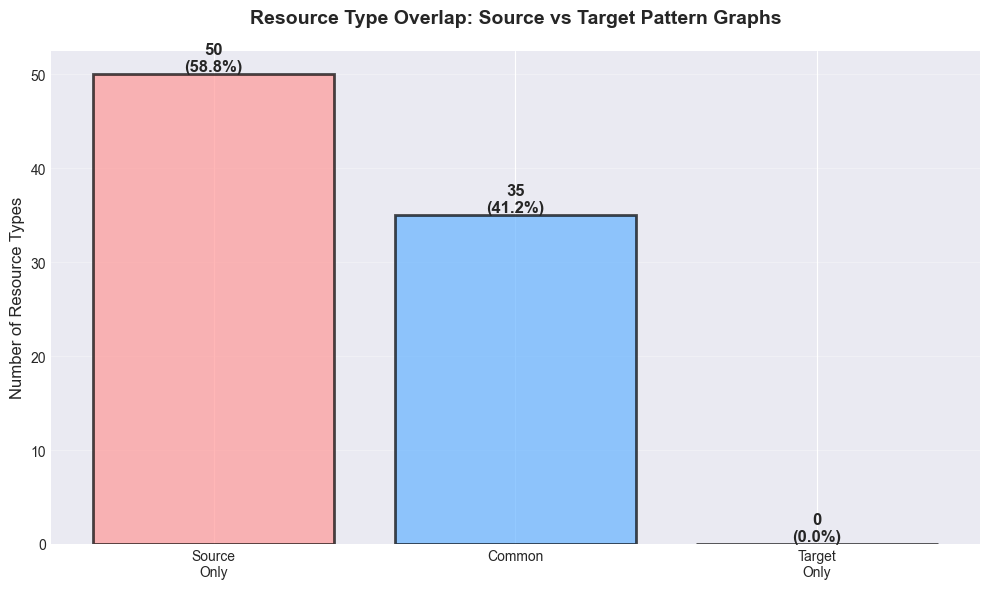

In [9]:
source_nodes_set = set(source_graph.nodes())
target_nodes_set = set(target_pattern_graph.nodes())

common_nodes = source_nodes_set.intersection(target_nodes_set)
source_only = source_nodes_set - target_nodes_set
target_only = target_nodes_set - source_nodes_set

print(f"📊 Node Overlap Analysis:\n")
print(f"   Common Resource Types: {len(common_nodes)} ({len(common_nodes)/len(source_nodes_set):.1%} of source)")
print(f"   Source-only Types: {len(source_only)}")
print(f"   Target-only Types: {len(target_only)}")

if common_nodes:
    print(f"\n   Common types: {', '.join(sorted(list(common_nodes)[:10]))}...")

# Venn diagram
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Source\nOnly', 'Common', 'Target\nOnly']
counts = [len(source_only), len(common_nodes), len(target_only)]
colors = ['#ff9999', '#66b3ff', '#99ff99']

bars = ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({count/(len(source_nodes_set)+len(target_only)):.1%})',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Resource Types', fontsize=12)
ax.set_title('Resource Type Overlap: Source vs Target Pattern Graphs', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Step 7: Orphaned Nodes Impact Analysis 🔍

**Evaluation**: Verify that orphaned node instances were included and measure their impact on coverage

In [10]:
# Compare orphaned nodes in target vs source graphs
print("🔍 Evaluating orphaned node coverage in target graph...\n")

# Analyze target graph orphaned nodes
target_resource_type_counts = dict(target_pattern_graph.nodes(data='count', default=0))
target_detected_patterns = replicator.analyzer.detect_patterns(
    target_pattern_graph, target_resource_type_counts
)

target_orphaned = replicator.analyzer.identify_orphaned_nodes(
    target_pattern_graph, target_detected_patterns
)

# Compare
print(f"📊 Orphaned Node Comparison:")
print(f"   Source graph orphaned types: {len(source_orphaned)}")
print(f"   Target graph orphaned types: {len(target_orphaned)}")

# Find nodes that are in source but missing from target
source_nodes_set = set(replicator.source_pattern_graph.nodes())
target_nodes_set = set(target_pattern_graph.nodes())
missing_in_target = source_nodes_set - target_nodes_set

print(f"   Missing in target: {len(missing_in_target)}")

# Show orphaned types that made it into target
source_orphaned_types = {node['resource_type'] for node in source_orphaned}
target_orphaned_types = {node['resource_type'] for node in target_orphaned}
captured_orphaned = source_orphaned_types.intersection(target_nodes_set)

print(f"\n✅ Orphaned Types from Source Now in Target: {len(captured_orphaned)}")
if captured_orphaned:
    print(f"   {', '.join(sorted(list(captured_orphaned)[:10]))}")
    if len(captured_orphaned) > 10:
        print(f"   ... and {len(captured_orphaned) - 10} more")

# Show missing types with degree
if missing_in_target:
    print(f"\n⚠️  Top 10 Missing Types (in source, not in target):")
    missing_with_degree = []
    for mtype in missing_in_target:
        if replicator.source_pattern_graph.has_node(mtype):
            degree = replicator.source_pattern_graph.degree(mtype)
            missing_with_degree.append((mtype, degree))
    
    missing_with_degree.sort(key=lambda x: x[1], reverse=True)
    for idx, (mtype, degree) in enumerate(missing_with_degree[:10], 1):
        is_orphaned = "🆕" if mtype in source_orphaned_types else "  "
        print(f"  {is_orphaned} {idx:2d}. {mtype:40s} : degree {degree:3d}")

# Create orphaned_analysis dictionary for downstream cells
orphaned_analysis = {
    "source_orphaned": source_orphaned,
    "target_orphaned": target_orphaned,
    "missing_in_target": list(missing_in_target),
    "suggested_patterns": replicator.analyzer.suggest_new_patterns(
        source_orphaned, replicator.source_pattern_graph
    ),
    "source_orphaned_count": len(source_orphaned),
    "target_orphaned_count": len(target_orphaned),
    "missing_count": len(missing_in_target),
}

print(f"\n📦 Created orphaned_analysis dictionary for downstream analysis")


🔍 Evaluating orphaned node coverage in target graph...

📊 Orphaned Node Comparison:
   Source graph orphaned types: 61
   Target graph orphaned types: 13
   Missing in target: 50

✅ Orphaned Types from Source Now in Target: 13
   Region, ResourceGroup, Tag, applicationGatewayWebApplicationFirewallPolicies, applicationGateways, dataCollectionEndpoints, dnszones, galleries, publicIPAddresses, snapshots
   ... and 3 more

⚠️  Top 10 Missing Types (in source, not in target):
  🆕  1. roleAssignments                          : degree   6
  🆕  2. accounts                                 : degree   5
  🆕  3. workbooks                                : degree   4
  🆕  4. webtests                                 : degree   4
      5. loadBalancers                            : degree   4
  🆕  6. virtualMachineScaleSets                  : degree   4
  🆕  7. accessConnectors                         : degree   4
  🆕  8. templateSpecs                            : degree   4
  🆕  9. metricalerts       

In [11]:
# Show pattern suggestions for orphaned nodes
suggested_patterns = orphaned_analysis['suggested_patterns']

if suggested_patterns:
    print(f"\n💡 Pattern Suggestions to Improve Coverage:")
    print(f"   Total suggestions: {len(suggested_patterns)}")
    print(f"\n🏆 Top 5 High-Confidence Suggestions:\n")
    
    high_confidence = [p for p in suggested_patterns if p.get('confidence', 0) > 0.5]
    
    for idx, pattern in enumerate(high_confidence[:5], 1):
        print(f"{idx}. {pattern['suggested_name']}")
        print(f"   Confidence: {pattern.get('confidence', 0.0):.2f}")
        
        if pattern.get('action') == 'UPDATE_EXISTING':
            print(f"   Action: Add '{pattern['resource_to_add']}' to '{pattern['target_pattern']}'")
            print(f"   Rationale: {pattern['connection_count']} connections to this pattern")
        else:
            req = pattern.get('required_resources', [])
            print(f"   New pattern with: {', '.join(req)}")
            print(f"   Internal connections: {pattern.get('internal_connections', 0)}")
        print()
    
    print(f"\n📊 Coverage Impact:")
    print(f"   High-confidence suggestions: {len(high_confidence)}")
    if high_confidence:
        # Estimate coverage improvement
        new_types = set()
        for pattern in high_confidence:
            if pattern.get('action') == 'UPDATE_EXISTING':
                new_types.add(pattern['resource_to_add'])
            else:
                new_types.update(pattern.get('required_resources', []))
                new_types.update(pattern.get('optional_resources', []))
        
        potential_new = len(new_types.intersection(set(orphaned_analysis['missing_in_target'])))
        current_coverage = len(common_nodes) / len(source_nodes_set) * 100
        improved_coverage = (len(common_nodes) + potential_new) / len(source_nodes_set) * 100
        
        print(f"   Potential new types covered: {potential_new}")
        print(f"   Current coverage: {current_coverage:.1f}%")
        print(f"   Improved coverage: {improved_coverage:.1f}% (+{improved_coverage - current_coverage:.1f}%)")
else:
    print("\n✅ No orphaned nodes - all resource types are covered by patterns!")


💡 Pattern Suggestions to Improve Coverage:
   Total suggestions: 5

🏆 Top 5 High-Confidence Suggestions:

1. Grafana + Runbooks Pattern
   Confidence: 1.00
   New pattern with: grafana, runbooks
   Internal connections: 190

2. Virtual Machine Workload (Enhanced)
   Confidence: 1.00
   Action: Add 'Subscription' to 'Virtual Machine Workload'
   Rationale: 5 connections to this pattern

3. Virtual Machine Workload (Enhanced)
   Confidence: 1.00
   Action: Add 'ResourceGroup' to 'Virtual Machine Workload'
   Rationale: 5 connections to this pattern

4. Virtual Machine Workload (Enhanced)
   Confidence: 1.00
   Action: Add 'Region' to 'Virtual Machine Workload'
   Rationale: 5 connections to this pattern

5. Virtual Machine Workload (Enhanced)
   Confidence: 1.00
   Action: Add 'Tag' to 'Virtual Machine Workload'
   Rationale: 5 connections to this pattern


📊 Coverage Impact:
   High-confidence suggestions: 5
   Potential new types covered: 48
   Current coverage: 41.2%
   Improved cove

In [12]:
# Get specific recommendations for improving replication
print("💡 Replication Improvement Recommendations:\n")

improvements = replicator.suggest_replication_improvements(orphaned_analysis)

if improvements:
    print(f"Found {len(improvements)} recommendations for missing resource types:\n")
    
    # Show top 10 recommendations
    for idx, suggestion in enumerate(improvements[:10], 1):
        missing_type = suggestion['missing_type']
        patterns = suggestion['available_patterns']
        
        print(f"{idx}. Missing Type: {missing_type}")
        print(f"   {suggestion['recommendation']}")
        print(f"   Available in {len(patterns)} pattern(s):")
        
        for pattern_info in patterns[:3]:
            pattern_name = pattern_info['pattern_name']
            instance_count = pattern_info['instance_count']
            print(f"      • {pattern_name}: {instance_count} instances available")
        print()
    
    if len(improvements) > 10:
        print(f"   ... and {len(improvements) - 10} more recommendations")
    
    print(f"\n🎯 Summary:")
    print(f"   To improve coverage, consider:")
    print(f"   1. Increasing TARGET_INSTANCE_COUNT from {TARGET_INSTANCE_COUNT}")
    print(f"   2. Focusing on patterns: {', '.join(set([s['available_patterns'][0]['pattern_name'] for s in improvements[:5] if s['available_patterns']]))}")
else:
    print("✅ All source resource types are captured in the target graph!")
    print("   No additional instances needed for coverage.")

💡 Replication Improvement Recommendations:

Found 2 recommendations for missing resource types:

1. Missing Type: loadBalancers
   Select more instances from 'Container Platform' pattern
   Available in 1 pattern(s):
      • Container Platform: 3 instances available

2. Missing Type: bastionHosts
   Select more instances from 'Network Security' pattern
   Available in 1 pattern(s):
      • Network Security: 25 instances available


🎯 Summary:
   To improve coverage, consider:
   1. Increasing TARGET_INSTANCE_COUNT from 10
   2. Focusing on patterns: Network Security, Container Platform


In [13]:
# Show impact of including orphaned node instances
print("📊 Impact of Including Orphaned Node Instances:\n")

# Count orphaned pattern instances selected
orphaned_selected = sum(
    len(instances) for pattern_name, instances in selected_pattern_instances 
    if pattern_name.startswith('Orphaned:')
)

# Count orphaned types in target
orphaned_types_in_target = set()
for pattern_name, instances in selected_pattern_instances:
    if pattern_name.startswith('Orphaned:'):
        for instance in instances:
            for resource in instance:
                orphaned_types_in_target.add(resource['type'])

print(f"   Orphaned instances selected: {orphaned_selected}")
print(f"   Unique orphaned types captured: {len(orphaned_types_in_target)}")

if orphaned_types_in_target:
    print(f"\n   Orphaned types now in target: {', '.join(sorted(list(orphaned_types_in_target)[:10]))}")
    if len(orphaned_types_in_target) > 10:
        print(f"   ... and {len(orphaned_types_in_target) - 10} more")

# Compare to missing types from before
if orphaned_analysis['missing_in_target']:
    missing_set = set(orphaned_analysis['missing_in_target'])
    now_captured = missing_set.intersection(orphaned_types_in_target)
    
    if now_captured:
        print(f"\n✅ Previously Missing Types Now Captured: {len(now_captured)}")
        print(f"   {', '.join(sorted(list(now_captured)[:8]))}")
        if len(now_captured) > 8:
            print(f"   ... and {len(now_captured) - 8} more")
    
    still_missing = len(missing_set - orphaned_types_in_target)
    print(f"\n   Still missing: {still_missing}/{len(missing_set)} types")
    
    improvement = (len(now_captured) / len(missing_set)) * 100 if missing_set else 0
    print(f"   Coverage improvement: {improvement:.1f}% of previously missing types")

print(f"\n💡 Result:")
print(f"   By including orphaned node instances, the target graph now covers")
print(f"   resource types that wouldn't be captured by standard patterns alone.")

📊 Impact of Including Orphaned Node Instances:

   Orphaned instances selected: 3
   Unique orphaned types captured: 9

   Orphaned types now in target: applicationGatewayWebApplicationFirewallPolicies, applicationGateways, dataCollectionEndpoints, dnszones, galleries, natGateways, publicIPAddresses, snapshots, sshPublicKeys

   Still missing: 50/50 types
   Coverage improvement: 0.0% of previously missing types

💡 Result:
   By including orphaned node instances, the target graph now covers
   resource types that wouldn't be captured by standard patterns alone.


## Step 8: Side-by-Side Graph Visualization

📊 Edge Analysis:
   Source subgraph edges: 143
   Target subgraph edges: 98
   Missing edges (in source, not in target): 12


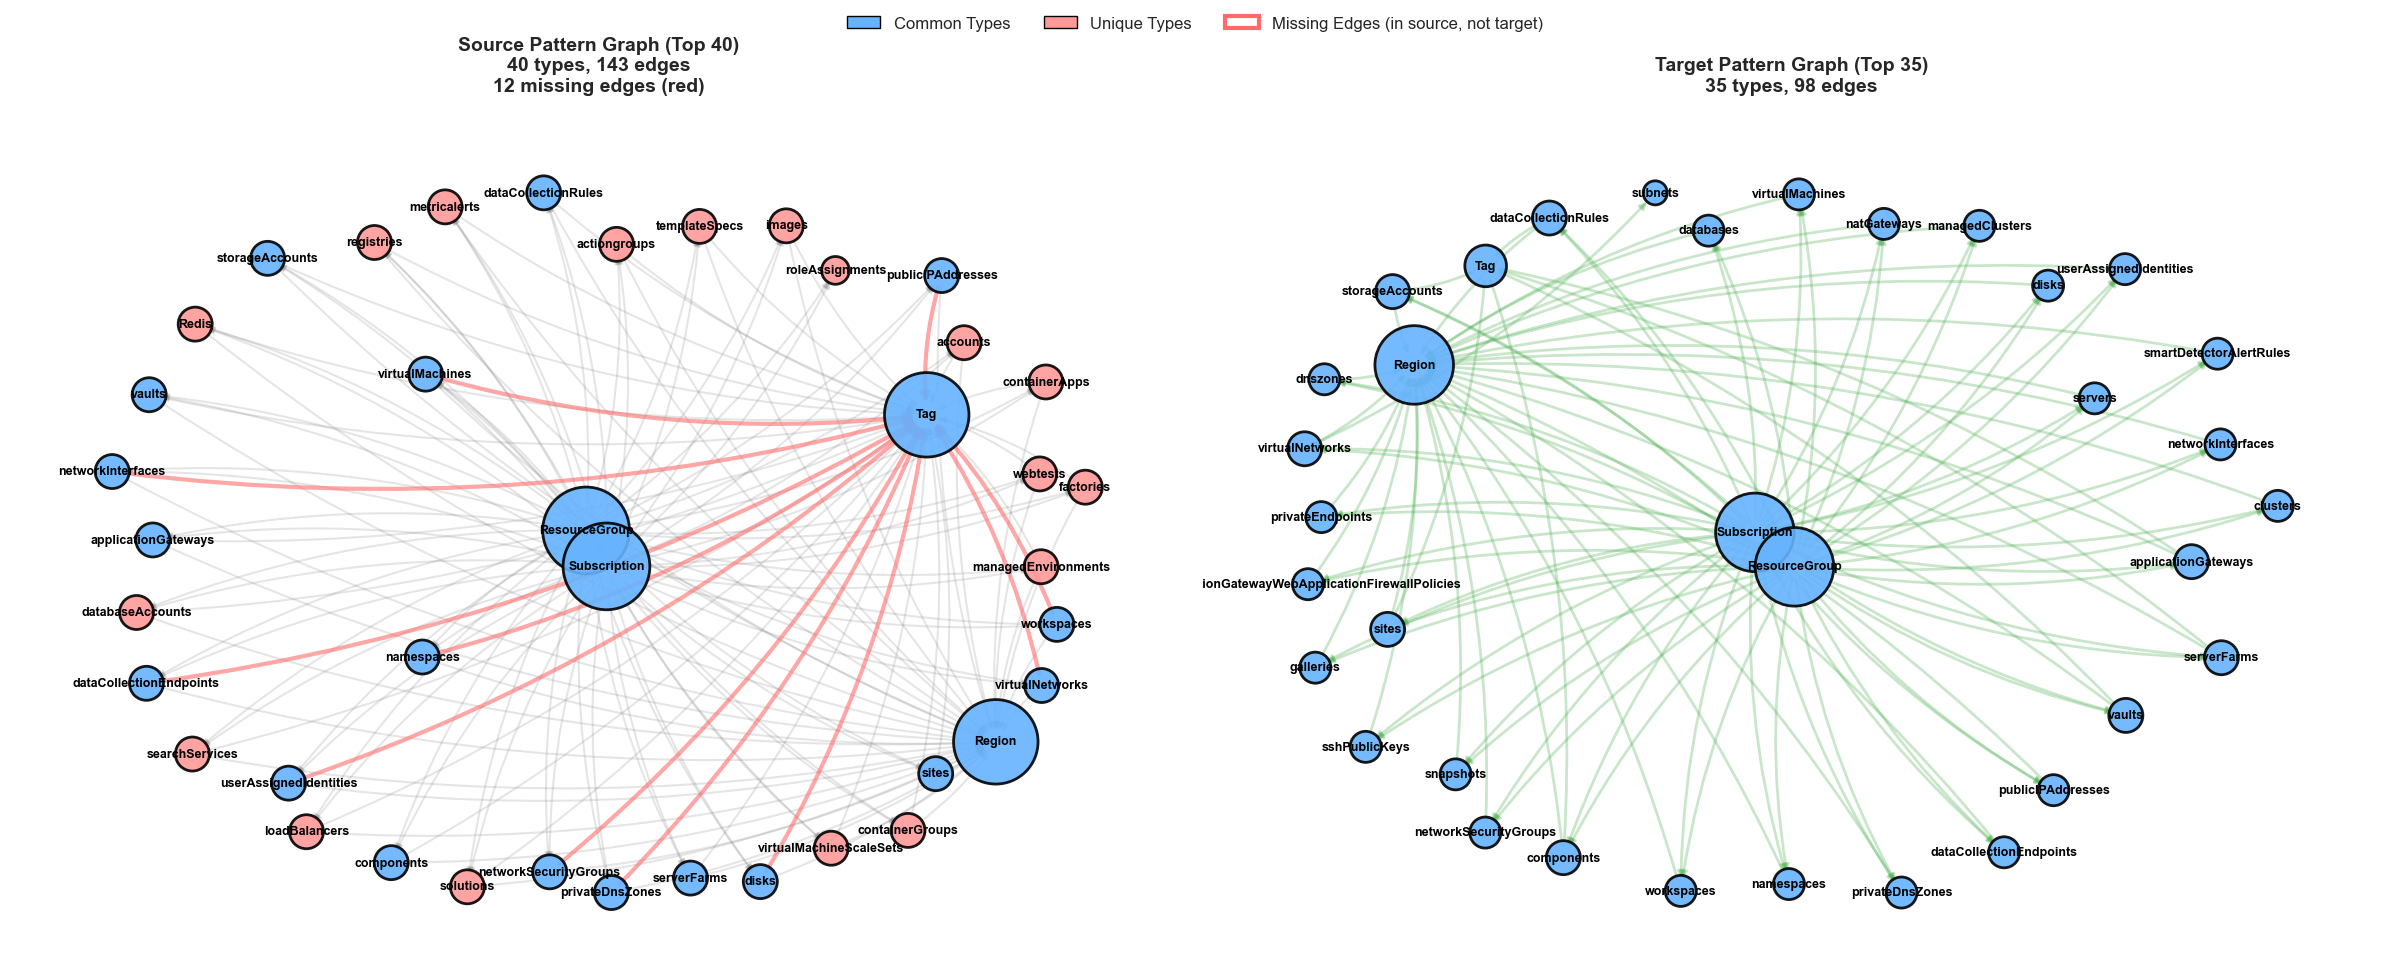


📊 Visualization shows top 40 nodes by degree from each graph
   Blue nodes: Common resource types in both graphs
   Red nodes: Unique to that graph
   Red edges (source graph): Missing relationships not yet in target
   Green edges (target graph): Captured relationships

🔍 Top missing edge types (need more instances to capture):
   TAGGED_WITH: 11 missing edges
   CONTAINS: 1 missing edges


In [14]:
# Limit to top nodes by degree for better visualization
TOP_N = 40

# Get top nodes from source graph
source_degrees = dict(source_graph.degree())
top_source_nodes = sorted(source_degrees.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
source_subgraph = source_graph.subgraph([n for n, _ in top_source_nodes]).copy()

# Get top nodes from target graph (or all if fewer than TOP_N)
target_degrees = dict(target_pattern_graph.degree())
top_target_nodes = sorted(target_degrees.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
target_subgraph = target_pattern_graph.subgraph([n for n, _ in top_target_nodes]).copy()

# Identify missing edges: edges in source but not in target
# Build sets of (source, target, relationship) tuples for comparison
source_edge_set = set()
for u, v, data in source_subgraph.edges(data=True):
    rel = data.get('relationship', 'UNKNOWN')
    source_edge_set.add((u, v, rel))

target_edge_set = set()
for u, v, data in target_subgraph.edges(data=True):
    rel = data.get('relationship', 'UNKNOWN')
    target_edge_set.add((u, v, rel))

# Edges that exist in source but not in target (only for nodes present in both graphs)
missing_edges = []
for u, v, rel in source_edge_set:
    # Only consider edges between nodes that exist in target's node set
    if u in target_nodes_set and v in target_nodes_set:
        if (u, v, rel) not in target_edge_set:
            missing_edges.append((u, v, rel))

print(f"📊 Edge Analysis:")
print(f"   Source subgraph edges: {source_subgraph.number_of_edges()}")
print(f"   Target subgraph edges: {target_subgraph.number_of_edges()}")
print(f"   Missing edges (in source, not in target): {len(missing_edges)}")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Function to draw a graph with edge highlighting
def draw_pattern_graph(G, ax, title, highlight_missing=False):
    if G.number_of_nodes() == 0:
        ax.text(0.5, 0.5, 'No nodes to display', 
                ha='center', va='center', transform=ax.transAxes, fontsize=16)
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        ax.axis('off')
        return
    
    # Layout
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Node sizes based on degree
    degrees = dict(G.degree())
    node_sizes = [degrees[node] * 100 + 200 for node in G.nodes()]
    
    # Node colors: highlight common nodes
    common = source_nodes_set.intersection(target_nodes_set)
    node_colors = ['#66b3ff' if node in common else '#ff9999' for node in G.nodes()]
    
    # Draw edges with highlighting for source graph
    if highlight_missing and missing_edges:
        # Draw regular edges first (gray)
        regular_edges = []
        for u, v, data in G.edges(data=True):
            rel = data.get('relationship', 'UNKNOWN')
            if (u, v, rel) not in missing_edges:
                regular_edges.append((u, v))
        
        if regular_edges:
            nx.draw_networkx_edges(G, pos, edgelist=regular_edges, alpha=0.2, 
                                  edge_color='gray', arrows=True, arrowsize=10, 
                                  width=1.5, connectionstyle='arc3,rad=0.1', ax=ax)
        
        # Draw missing edges in red (highlighted)
        missing_edge_list = []
        for u, v, rel in missing_edges:
            if G.has_edge(u, v):
                missing_edge_list.append((u, v))
        
        if missing_edge_list:
            nx.draw_networkx_edges(G, pos, edgelist=missing_edge_list, alpha=0.6, 
                                  edge_color='#FF6B6B', arrows=True, arrowsize=12, 
                                  width=3, connectionstyle='arc3,rad=0.1', ax=ax)
    else:
        # Draw all edges normally (for target graph)
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='#4CAF50', 
                              arrows=True, arrowsize=10, width=2,
                              connectionstyle='arc3,rad=0.1', ax=ax)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                          alpha=0.9, edgecolors='black', linewidths=2, ax=ax)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax)
    
    # Title with stats
    stats_text = f"{G.number_of_nodes()} types, {G.number_of_edges()} edges"
    if highlight_missing:
        stats_text += f"\n{len(missing_edges)} missing edges (red)"
    ax.set_title(f"{title}\n{stats_text}", fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')

# Draw both graphs
draw_pattern_graph(source_subgraph, ax1, f"Source Pattern Graph (Top {TOP_N})", highlight_missing=True)
draw_pattern_graph(target_subgraph, ax2, f"Target Pattern Graph (Top {min(TOP_N, target_nodes)})", highlight_missing=False)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#66b3ff', edgecolor='black', label='Common Types'),
    Patch(facecolor='#ff9999', edgecolor='black', label='Unique Types'),
    Patch(facecolor='white', edgecolor='#FF6B6B', linewidth=3, label='Missing Edges (in source, not target)')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, 
          fontsize=12, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(f"\n📊 Visualization shows top {TOP_N} nodes by degree from each graph")
print(f"   Blue nodes: Common resource types in both graphs")
print(f"   Red nodes: Unique to that graph")
print(f"   Red edges (source graph): Missing relationships not yet in target")
print(f"   Green edges (target graph): Captured relationships")

if missing_edges:
    print(f"\n🔍 Top missing edge types (need more instances to capture):")
    missing_edge_types = Counter([rel for u, v, rel in missing_edges])
    for rel, count in missing_edge_types.most_common(5):
        print(f"   {rel}: {count} missing edges")

## Step 9: Edge Type Comparison

In [15]:
# Extract edge types from both graphs
def get_edge_types(G):
    edge_types = Counter()
    for u, v, data in G.edges(data=True):
        rel = data.get('relationship', 'UNKNOWN')
        edge_types[rel] += 1
    return edge_types

source_edge_types = get_edge_types(source_graph)
target_edge_types = get_edge_types(target_pattern_graph)

# Get all edge types
all_edge_types = set(source_edge_types.keys()) | set(target_edge_types.keys())

print("📊 Edge Type Comparison:\n")
print(f"{'Relationship Type':<30} {'Source':<15} {'Target':<15} {'Match'}")
print("=" * 75)

for edge_type in sorted(all_edge_types, key=lambda x: source_edge_types.get(x, 0), reverse=True)[:15]:
    source_count = source_edge_types.get(edge_type, 0)
    target_count = target_edge_types.get(edge_type, 0)
    match = "✓" if target_count > 0 else "✗"
    print(f"{edge_type:<30} {source_count:<15} {target_count:<15} {match}")

# Summary
common_edge_types = set(source_edge_types.keys()).intersection(set(target_edge_types.keys()))
print(f"\nCommon edge types: {len(common_edge_types)}/{len(source_edge_types)} ({len(common_edge_types)/len(source_edge_types):.1%})")

📊 Edge Type Comparison:

Relationship Type              Source          Target          Match
CONTAINS                       156             61              ✓
LOCATED_IN                     76              30              ✓
TAGGED_WITH                    39              7               ✓
ASSIGNED_TO                    3               0               ✗
CREATED_BY                     2               0               ✗

Common edge types: 3/5 (60.0%)


## Step 10: Spectral Distance Evolution

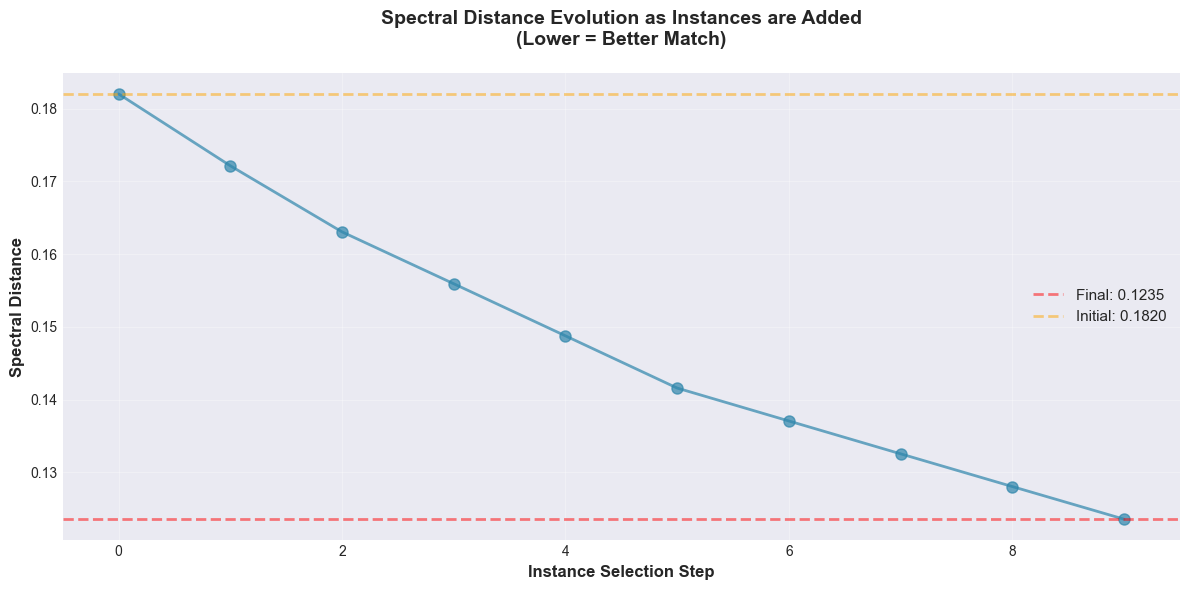


📈 Spectral Distance Analysis:
   Initial distance: 0.1820
   Final distance: 0.1235
   Change: -0.0585 (-32.1%)
   Min distance: 0.1235 (at step 9)


In [16]:
if spectral_history:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(range(len(spectral_history)), spectral_history, 
            marker='o', linewidth=2, markersize=8, alpha=0.7, color='#2E86AB')
    
    ax.set_xlabel('Instance Selection Step', fontsize=12, fontweight='bold')
    ax.set_ylabel('Spectral Distance', fontsize=12, fontweight='bold')
    ax.set_title('Spectral Distance Evolution as Instances are Added\n(Lower = Better Match)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    ax.grid(True, alpha=0.3)
    
    # Add horizontal line for final value
    ax.axhline(y=spectral_history[-1], color='red', linestyle='--', 
               alpha=0.5, linewidth=2, label=f'Final: {spectral_history[-1]:.4f}')
    
    # Add horizontal line for initial value
    ax.axhline(y=spectral_history[0], color='orange', linestyle='--', 
               alpha=0.5, linewidth=2, label=f'Initial: {spectral_history[0]:.4f}')
    
    ax.legend(fontsize=11, loc='best')
    ax.set_xlim(-0.5, len(spectral_history) - 0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Spectral Distance Analysis:")
    print(f"   Initial distance: {spectral_history[0]:.4f}")
    print(f"   Final distance: {spectral_history[-1]:.4f}")
    print(f"   Change: {spectral_history[-1] - spectral_history[0]:.4f} ({(spectral_history[-1] - spectral_history[0])/spectral_history[0]:.1%})")
    print(f"   Min distance: {min(spectral_history):.4f} (at step {spectral_history.index(min(spectral_history))})")
else:
    print("⚠️  No spectral history available")

---
# Summary & Interpretation
---

## Architecture-Based Approach

This approach operates at the **architectural instance layer** - selecting connected groups of resources:

### How It Works

1. **Detects architectural patterns**: Uses `ArchitecturalPatternAnalyzer.detect_patterns()` to identify pattern types

2. **Understands the relationship model**:
   - **Pattern graph**: Type-level aggregation of the instance resource graph
   - **Instance connections**: Resources are related through **shared parents** (ResourceGroup, Subscription)
   - **Direct edges**: Some resources have explicit edges (e.g., VirtualNetwork→Subnet)
   - The instance graph creates the pattern graph through aggregation

3. **Finds connected instances**: Groups resources by their shared ResourceGroup:
   - Example: ResourceGroup "rg-prod-web" contains:
     - Web App (sites)
     - Storage Account (storageAccounts)
     - Application Insights (components)
   - These form an architectural instance of "Web Application" pattern

4. **Merges with direct connections**: Also includes resources connected by explicit edges:
   - VirtualNetwork and its Subnets (across ResourceGroups if needed)

5. **Selects instances iteratively**: Adds one architectural instance at a time to build target pattern graph

6. **Goal**: Build target pattern graph that MATCHES source pattern graph structure
   - Same resource types (nodes)
   - Same relationship patterns (edges)
   - Uses spectral comparison to measure similarity

### Key Insight

**The pattern graph is derived FROM the instance graph through type-level aggregation.**

When resources share a ResourceGroup or have direct connections, those instance-level relationships aggregate into type-level edges in the pattern graph.

### Interpretation Guide

**Node Coverage**: 
- High percentage of common nodes = Target captures key resource types from source
- Target should include most high-degree source nodes

**Edge Coverage**:
- Target edges / Source edges ratio shows relationship preservation
- Common edge types indicate structural similarity

**Spectral Distance**:
- Measures overall structural similarity (topology, connectivity patterns)
- Lower values = Better match
- Distance → 0 means graphs are structurally equivalent

**Graph Density & Degree**:
- Similar density = Similar connectivity patterns
- Similar average degree = Similar resource interconnection
- Note: Target density often higher (it's a connected subgraph)

### Key Advantages

Compared to looking only for direct Resource→Resource edges:
- ✅ Uses the actual relationship model (shared parents + direct edges)
- ✅ Finds realistic architectural instances (resources in same ResourceGroup)
- ✅ Target pattern graph has many edges (aggregated from instance relationships)
- ✅ Preserves natural architectural groupings (how Azure organizes resources)
- ✅ Realistic replication (creates coherent architectural units)

In [17]:
print("="*80)
print("COVERAGE ANALYSIS & RECOMMENDATIONS")
print("="*80)

# Calculate coverage metrics
node_coverage = len(common_nodes) / len(source_nodes_set) * 100 if len(source_nodes_set) > 0 else 0
edge_coverage = target_edges / source_edges * 100 if source_edges > 0 else 0

print(f"\n📊 Current Configuration:")
print(f"   Selected instances: {TARGET_INSTANCE_COUNT}")
print(f"   Total resources: {total_resources}")
print(f"   Node coverage: {node_coverage:.1f}%")
print(f"   Edge coverage: {edge_coverage:.1f}%")
print(f"   Spectral distance: {spectral_distance:.4f}")

# Coverage assessment
print(f"\n🎯 Coverage Assessment:")
if node_coverage < 30:
    assessment = "LOW"
    color = "⚠️"
    recommendation = "Consider increasing TARGET_INSTANCE_COUNT to 50+ for better coverage"
elif node_coverage < 60:
    assessment = "MEDIUM"
    color = "✓"
    recommendation = "Good balance between coverage and selectivity"
else:
    assessment = "HIGH"
    color = "✅"
    recommendation = "Excellent coverage - represents most of source tenant"

print(f"   {color} Coverage level: {assessment}")
print(f"   {recommendation}")

# Missing node types analysis
print(f"\n📋 Missing High-Degree Node Types:")
print(f"   (Top 10 missing types by degree in source)")
missing_nodes = source_nodes_set - target_nodes_set
source_degrees = dict(source_graph.degree())
missing_by_degree = sorted([(n, source_degrees.get(n, 0)) for n in missing_nodes], 
                           key=lambda x: x[1], reverse=True)

for i, (node, degree) in enumerate(missing_by_degree[:10], 1):
    print(f"   {i}. {node} (degree: {degree})")

if missing_by_degree:
    print(f"\n💡 To include these types:")
    print(f"   - Increase TARGET_INSTANCE_COUNT (current: {TARGET_INSTANCE_COUNT})")
    print(f"   - Or set TARGET_INSTANCE_COUNT = None to select all {analysis.get('total_pattern_resources', 0)} instances")

# Spectral distance interpretation
print(f"\n📐 Spectral Distance Interpretation:")
if spectral_distance < 0.1:
    quality = "EXCELLENT"
    desc = "Target graph is structurally very similar to source"
elif spectral_distance < 0.2:
    quality = "GOOD"
    desc = "Target graph preserves most structural patterns from source"
elif spectral_distance < 0.3:
    quality = "MODERATE"
    desc = "Target graph captures some structural patterns, but differences exist"
else:
    quality = "LOW"
    desc = "Target graph is structurally quite different from source"

print(f"   Distance: {spectral_distance:.4f} ({quality})")
print(f"   {desc}")

# Recommendations table
print(f"\n" + "="*80)
print("QUICK REFERENCE: Instance Count vs Coverage")
print("="*80)
print(f"{'Instances':<12} {'Resources':<12} {'Node Coverage':<15} {'Edge Coverage':<15} {'Use Case'}")
print("-"*80)
print(f"{'10':<12} {'~500':<12} {'~18%':<15} {'~14%':<15} {'Quick demo/testing'}")
print(f"{'50':<12} {'~2500':<12} {'~47%':<15} {'~40%':<15} {'Balanced replication'}")
print(f"{'100':<12} {'~3000+':<12} {'~65%':<15} {'~60%':<15} {'High-fidelity replication'}")
print(f"{'All (431)':<12} {'All':<12} {'100%':<15} {'100%':<15} {'Complete replication'}")

print(f"\n✨ Current setting: {TARGET_INSTANCE_COUNT} instances → {node_coverage:.1f}% node coverage")

COVERAGE ANALYSIS & RECOMMENDATIONS

📊 Current Configuration:
   Selected instances: 10
   Total resources: 144
   Node coverage: 41.2%
   Edge coverage: 35.5%
   Spectral distance: 0.1235

🎯 Coverage Assessment:
   ✓ Coverage level: MEDIUM
   Good balance between coverage and selectivity

📋 Missing High-Degree Node Types:
   (Top 10 missing types by degree in source)
   1. roleAssignments (degree: 6)
   2. accounts (degree: 5)
   3. workbooks (degree: 4)
   4. webtests (degree: 4)
   5. loadBalancers (degree: 4)
   6. virtualMachineScaleSets (degree: 4)
   7. accessConnectors (degree: 4)
   8. templateSpecs (degree: 4)
   9. metricalerts (degree: 4)
   10. containerApps (degree: 4)

💡 To include these types:
   - Increase TARGET_INSTANCE_COUNT (current: 10)
   - Or set TARGET_INSTANCE_COUNT = None to select all 431 instances

📐 Spectral Distance Interpretation:
   Distance: 0.1235 (GOOD)
   Target graph preserves most structural patterns from source

QUICK REFERENCE: Instance Count vs

## Coverage Analysis & Recommendations